### Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
#from keras.preprocessing.text import one_hot
#from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model

In [ ]:
# import os
# os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
# os.environ["GRAPHVIZ_DOT"] = r"C:\Program Files\Graphviz\bin\dot.exe"
# import shutil, graphviz, pydot, tensorflow as tf
# print("dot.exe:", shutil.which("dot"))
# print("graphviz  pkg:", graphviz.__version__)
# print("pydot     pkg:", pydot.__version__)

dot.exe: C:\Program Files\Graphviz\bin\dot.EXE
graphviz  pkg: 0.20.3
pydot     pkg: 4.0.0


<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

In [20]:
# import zipfile
# with zipfile.ZipFile("spa-eng.zip", 'r') as zip_ref:
#     zip_ref.extractall()

In [21]:
# dataset_file

text_file = "./clase/spa-eng/spa.txt"
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 118964

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964


In [22]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

In [23]:
# # Descargar la carpeta de dataset

# import os
# if os.access('spa-eng', os.F_OK) is False:
#     if os.access('spa-eng.zip', os.F_OK) is False:
#         !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
#     !unzip -q spa-eng.zip
# else:
#     print("El dataset ya se encuentra descargado")

### 2 - Preprocesamiento

In [24]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 30000
# Vamos a necesitar un tokenizador para cada idioma

In [25]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
#from keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47


In [26]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_output_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_output_len)

Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [27]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 47
max_output_len = 50

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [28]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_output_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [ ]:
# from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')
# decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
# decoder_targets.shape (5948200, 26342)
# decoder_output_sequences.shape (118964, 50)

### 3 - Preparar los embeddings

In [30]:
from gensim.models.fasttext import load_facebook_vectors
model_embeddings = load_facebook_vectors("clase/cc.en.300.bin")  
from gensim.models.fasttext import load_facebook_vectors
model_embeddings_es = load_facebook_vectors("clase/cc.es.300.bin")
vocab_size_in  = max(word2idx_inputs .values()) + 1   
vocab_size_out = max(word2idx_outputs.values()) + 1   
embed_dim = 300
# Inglés
embedding_matrix = np.zeros((vocab_size_in, embed_dim), dtype=np.float32)
for w, idx in word2idx_inputs.items():
    # idx incluye todos los valores hasta max_index
    if w in model_embeddings:
        embedding_matrix[idx] = model_embeddings[w]
# Español
embedding_matrix_es = np.zeros((vocab_size_out, embed_dim), dtype=np.float32)
for w, idx in word2idx_outputs.items():
    if w in model_embeddings_es:
        embedding_matrix_es[idx] = model_embeddings_es[w]
print(embedding_matrix.shape)
print(embedding_matrix_es.shape)
nb_words = embedding_matrix.shape[0]                # Vocablos en Inglés
num_words_output = embedding_matrix_es.shape[0]     # Vocablos en Español

(13525, 300)
(26342, 300)


### 4 - Entrenar el modelo

In [31]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 192

# Encoder Inglés
encoder_inputs  = Input(shape=(max_input_len,), name='encoder_input')
encoder_embedding = Embedding(
        input_dim=nb_words,              # tamaño vocab inglés
        output_dim=embed_dim,
        weights=[embedding_matrix],      # FastText inglés
        input_length=max_input_len,
        trainable=False,                 # congelado
        mask_zero=True)                  # ignora <pad>=0 en LSTM

encoder_embedded = encoder_embedding(encoder_inputs)
encoder_lstm   = LSTM(n_units, return_state=True, name='encoder_lstm')
_, state_h, state_c = encoder_lstm(encoder_embedded)
encoder_states = [state_h, state_c]

# Decoder Español
decoder_inputs = Input(shape=(max_output_len,), name='decoder_input')
decoder_embedding = Embedding(
        input_dim=num_words_output,      # tamaño vocab español
        output_dim=embed_dim,
        weights=[embedding_matrix_es],   # FastText español
        input_length=max_output_len,
        trainable=False,
        mask_zero=True)

decoder_embedded = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

Seq2Seq = Model([encoder_inputs, decoder_inputs], decoder_outputs)

class AdamLRM(tf.keras.optimizers.Adam):
    def __init__(self, lr_multipliers=None, **kw):
        super().__init__(**kw)
        self.lr_multipliers = lr_multipliers or {}
    def apply_gradients(self, grads_and_vars, **kw):
        scaled = []
        for g, v in grads_and_vars:
            mult = next((m for k, m in self.lr_multipliers.items() if k in v.name), 1.0)
            scaled.append((g * mult, v))
        return super().apply_gradients(scaled, **kw)

opt = AdamLRM(
    lr_multipliers={"decoder_embedding": 0.1},   # 0.1 × LR base
    learning_rate=0.01
)

Seq2Seq.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

Seq2Seq.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 47, 300)   │  4,057,500 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 47)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 50, 300)   │  7,902,600 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 192),     │    378,624 │ embedding_2[0][0… │
│                     │ (None, 192),      │            │ not_equal_3[0][0] │
│                     │ (None, 192)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 50, 192), │    378,624 │ embedding_3[0][0… │
│                     │ (None, 192),      │            │ encoder_lstm[0][… │
│                     │ (None, 192)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 50, 26342) │  5,084,006 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,801,354 (67.91 MB)

 Trainable params: 5,841,254 (22.28 MB)

 Non-trainable params: 11,960,100 (45.62 MB)

In [32]:
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)      # Debe ser (N, 16)
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)      # Debe ser (N, 16)

encoder_input_sequences.shape: (118964, 47)
decoder_input_sequences.shape: (118964, 50)


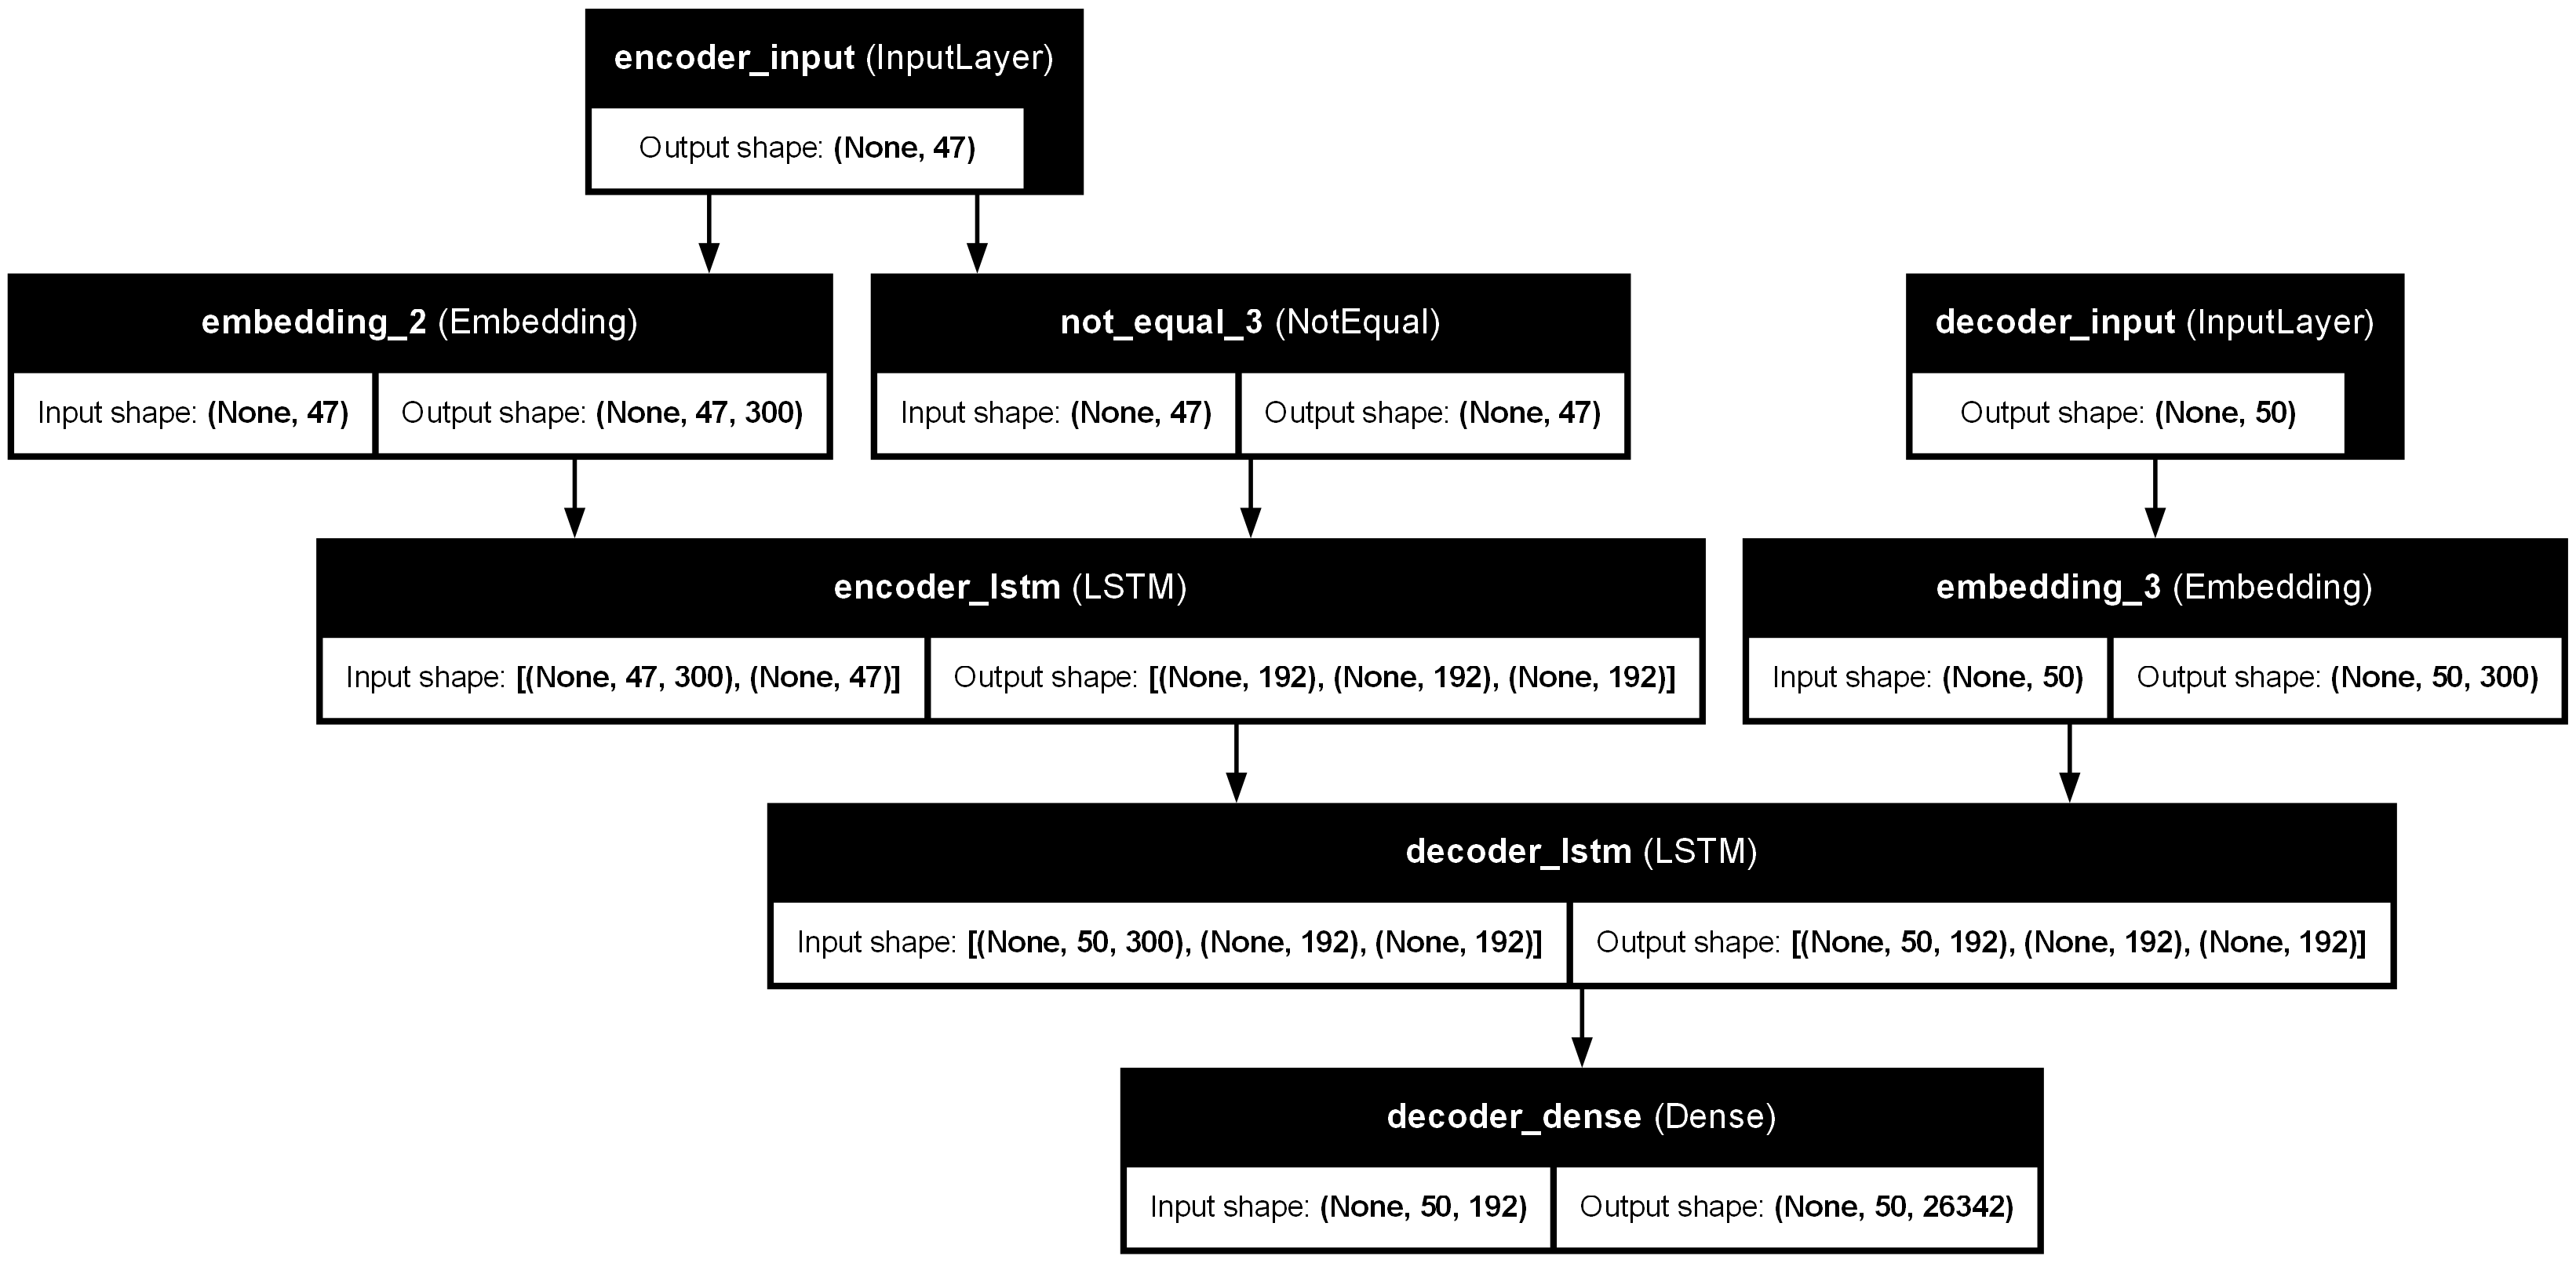

In [33]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(Seq2Seq, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

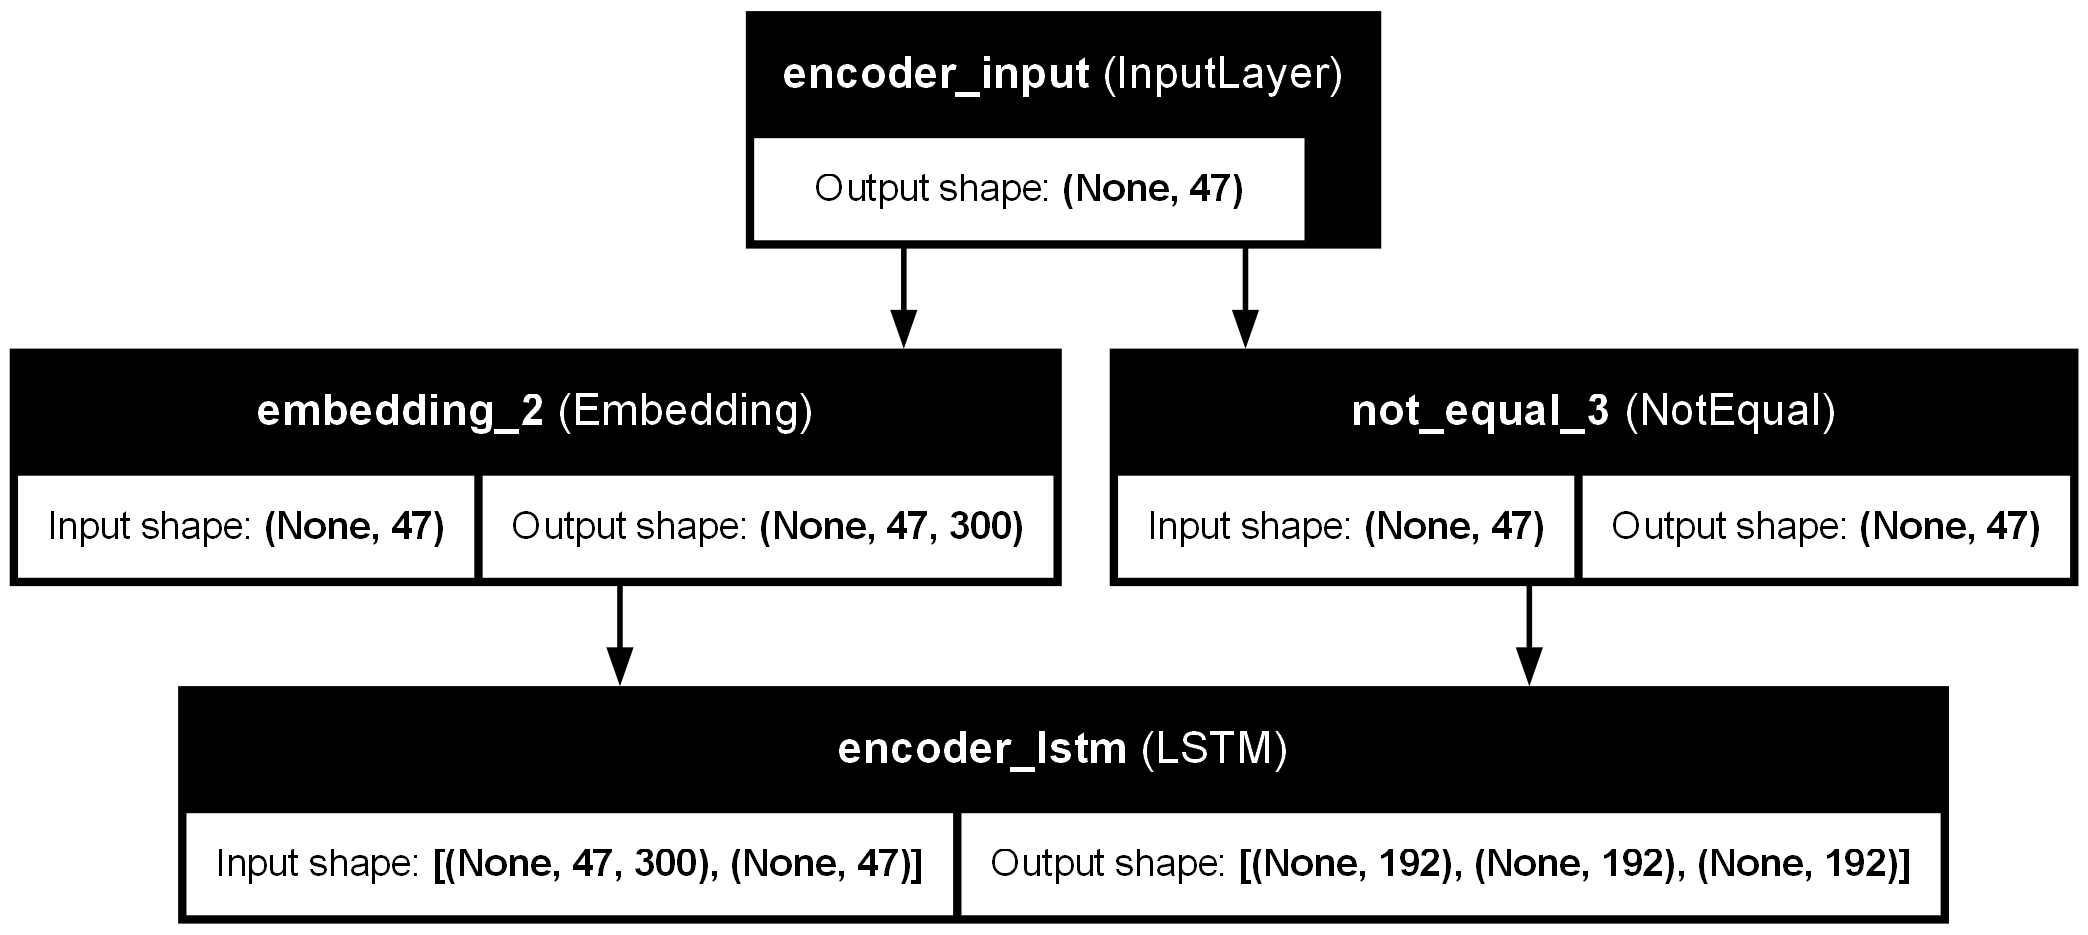

In [34]:
# Modelo solo encoder
# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

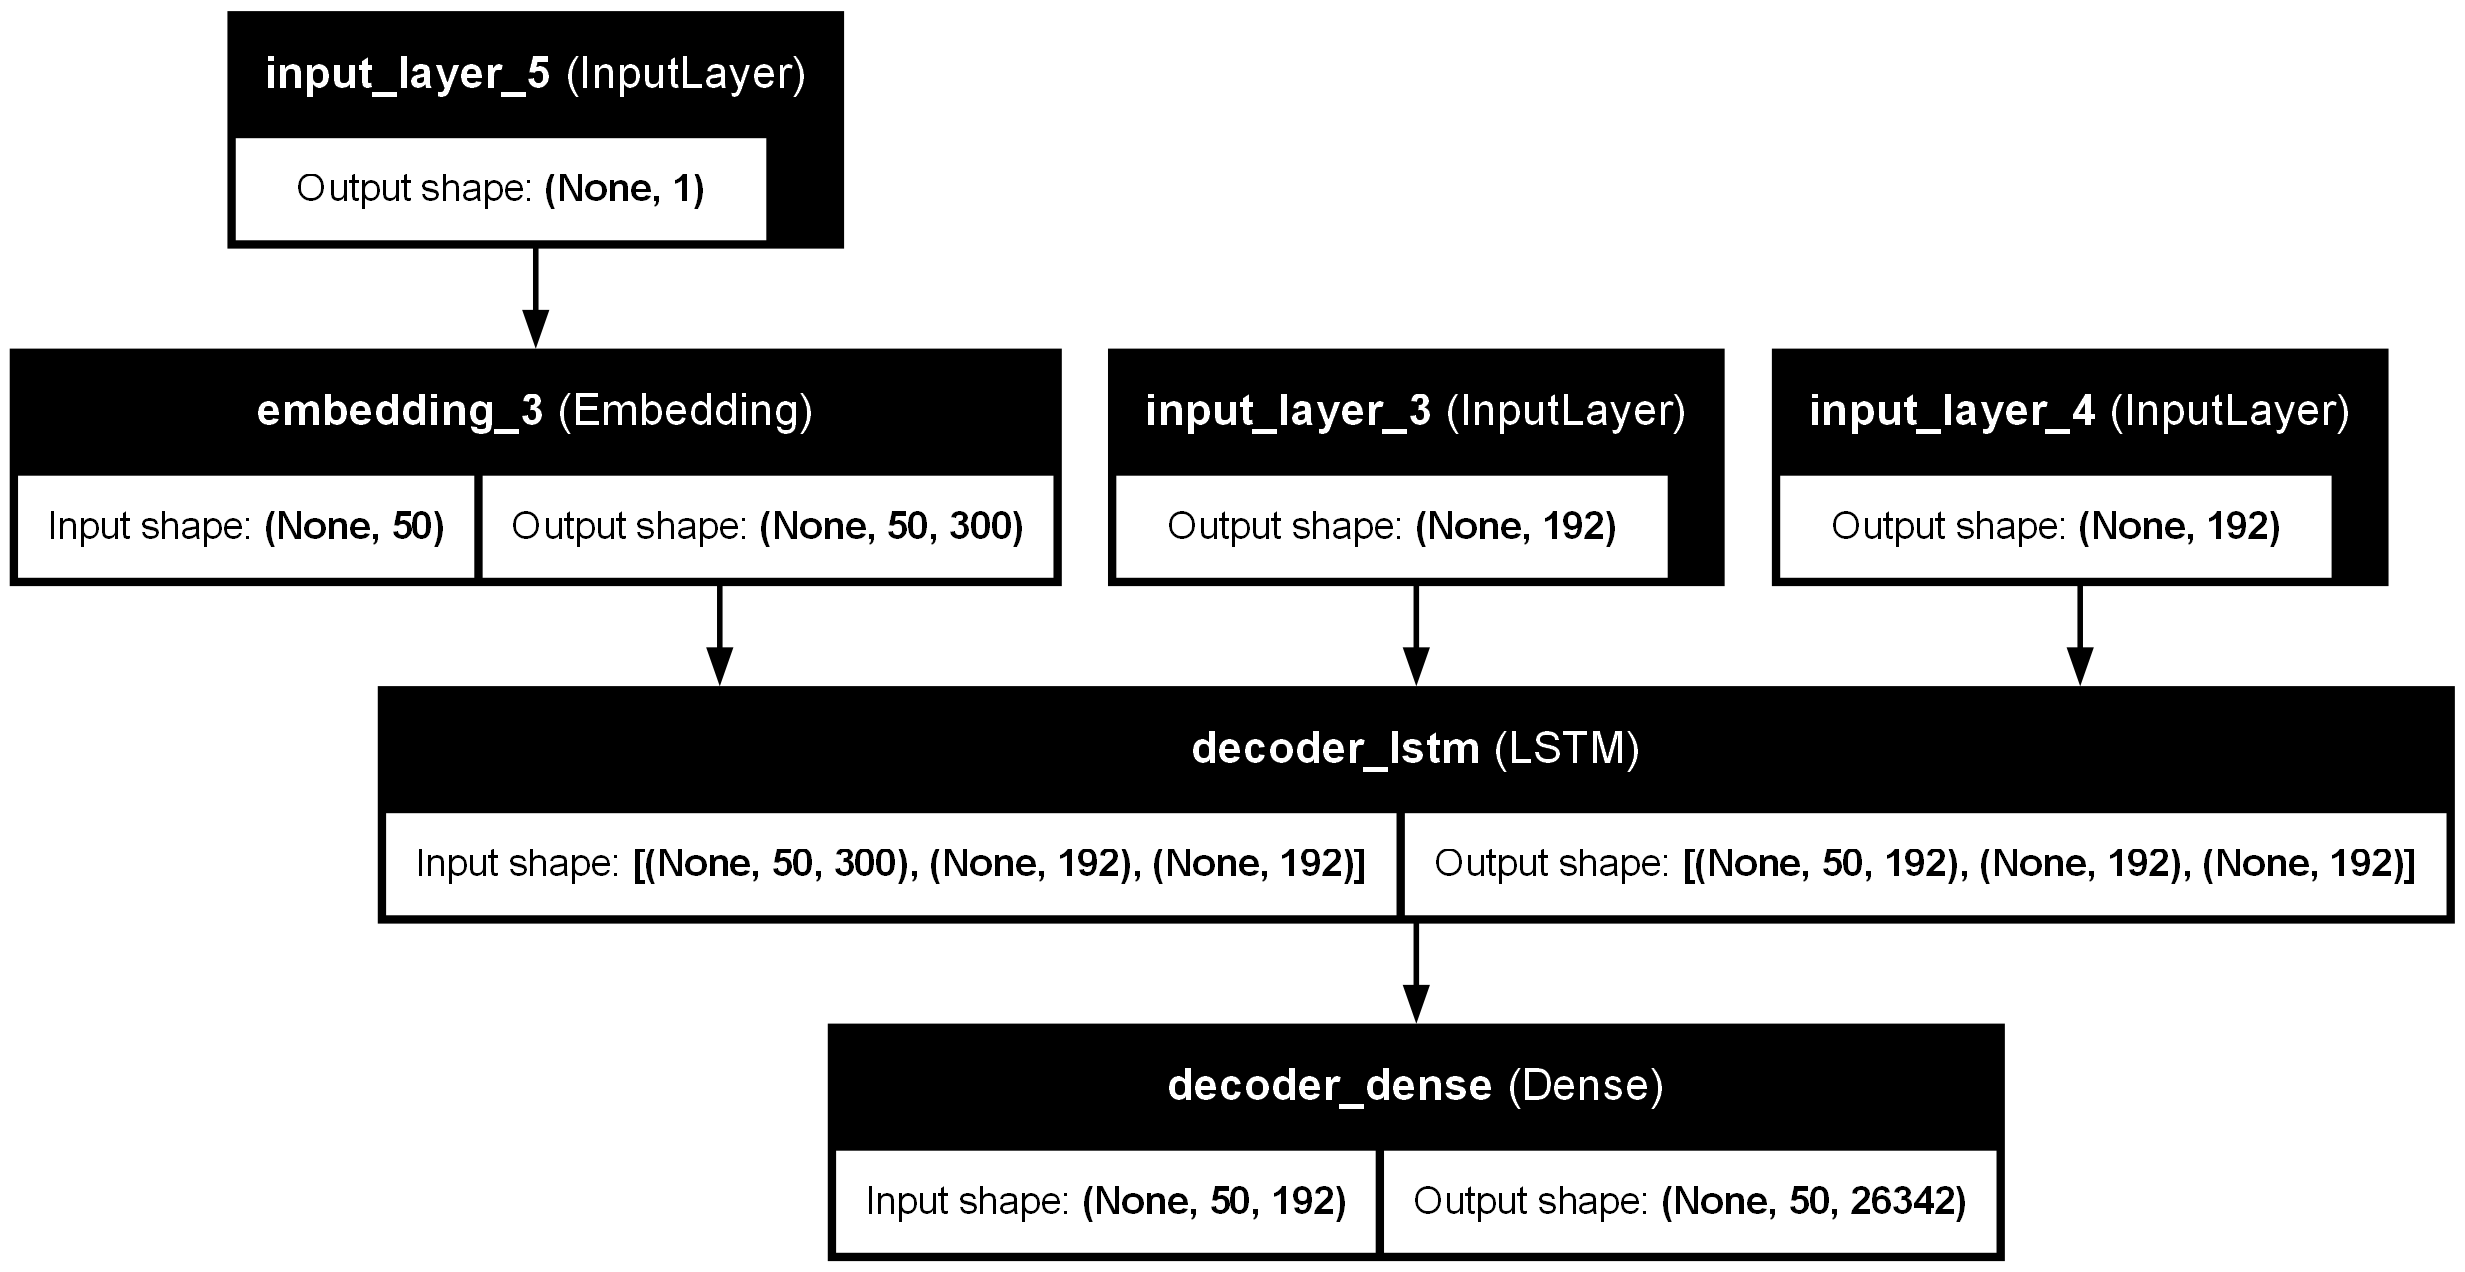

In [35]:
# Modelo solo decoder (para realizar inferencia)
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
display(encoder_model.summary())
display(decoder_model.summary())
print("\n--- Capas embedding realmente dentro de encoder_model ---")
for l in encoder_model.layers:
    if isinstance(l, tf.keras.layers.Embedding):
        w = l.get_weights()[0]             # matriz (vocab, embed_dim)
        print(f"{l.name:25s}  input_dim={l.input_dim:<6d}  "
              f"peso.shape={w.shape}")

print("\n--- Capas embedding realmente dentro de decoder_model ---")
for l in decoder_model.layers:
    if isinstance(l, tf.keras.layers.Embedding):
        w = l.get_weights()[0]             # matriz (vocab, embed_dim)
        print(f"{l.name:25s}  input_dim={l.input_dim:<6d}  "
              f"peso.shape={w.shape}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 47, 300)   │  4,057,500 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 47)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 192),     │    378,624 │ embedding_2[0][0… │
│                     │ (None, 192),      │            │ not_equal_3[0][0] │
│                     │ (None, 192)]      │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,436,124 (16.92 MB)

 Trainable params: 378,624 (1.44 MB)

 Non-trainable params: 4,057,500 (15.48 MB)

None

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 300)    │  7,902,600 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 192)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 192)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 192),  │    378,624 │ embedding_3[1][0… │
│                     │ (None, 192),      │            │ input_layer_3[0]… │
│                     │ (None, 192)]      │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 1, 26342)  │  5,084,006 │ decoder_lstm[1][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,365,230 (50.98 MB)

 Trainable params: 5,462,630 (20.84 MB)

 Non-trainable params: 7,902,600 (30.15 MB)

None


--- Capas embedding realmente dentro de encoder_model ---
embedding_2                input_dim=13525   peso.shape=(13525, 300)

--- Capas embedding realmente dentro de decoder_model ---
embedding_3                input_dim=26342   peso.shape=(26342, 300)


In [37]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # métrica que se vigila
    patience=6,               # nº de epochs sin mejora antes de frenar
    min_delta=1e-4,           # mejora mínima que se considera significativa
    mode='min',               # 'min' porque queremos que val_loss baje
    restore_best_weights=True # al parar, deja los pesos del mejor epoch
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_Seq2Seq.keras', monitor='val_loss',
    save_best_only=True, mode='min')

In [ ]:
pad_token = 0
sample_weights = (decoder_output_sequences != pad_token).astype("float32")
hist = Seq2Seq.fit(
    [encoder_input_sequences, decoder_input_sequences],      
    decoder_output_sequences,                                 
    sample_weight=sample_weights,
    batch_size=128,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)

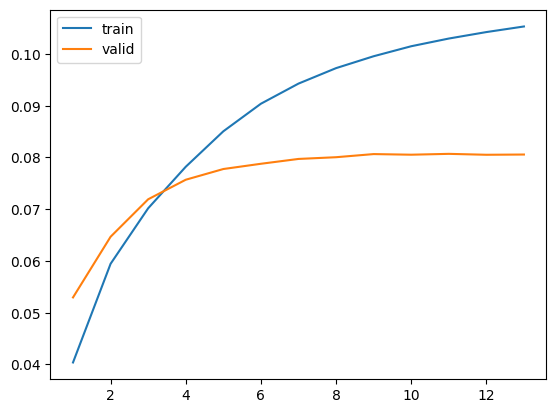

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [ ]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)
    
    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_output_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input: You look a little embarrassed.
Response: te ves una pregunta


In [ ]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [18, 199, 126, 2318]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   18  199  126 2318]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Response: mi madre dijo a tom


### 6 - Conclusión

Keras tiene la dificultad de que Tensorflow en su última versión soporta hasta: https://www.tensorflow.org/install/source?hl=en#gpu (Tensorflow 2.19 - CUDA 12.5) 
```
+-----------------------------------------------------------------------------------------+ 
| NVIDIA-SMI 576.40                 Driver Version: 576.40         CUDA Version: 12.9     | 
|-----------------------------------------+------------------------+----------------------+ 
```
Para este setup se tuvo que usar CPU, con lo que el entrenamiento fue mucho mas lento. \
Se optó omitir `to_categorical` para optimizar el uso de memoria RAM, con este cambio se pudo cargar todo el dataset de 118964 pares en-es. 
- decoder_targets.shape -> (5948200, 26342)
- decoder_output_sequences.shape -> (118964, 50)





Se utilizaron embeddings pre entrenados de FastText de 300 dims para el inglés y el español, con el fin de aumentar la capacidad de representación semántica. \
Para el caso del español se dejo un pequeño learning rate con el fin de alinear los espacios vectoriales haciendo fine tuning.

Se omitió el padding en el crossEntropy para no falcear las métricas, dado que no se debe considerar el idx 0 como predicción correcta. 

Se aumentaron los parámetros en las redes LSTM con el fin de captar mas relaciones, pero no en exceso ya que se ve que el modelo se estanca en el aprendizaje.

Finalmente, las traducciones mejoraron un poco, pero sigue siendo impreciso para múltiples ejemplos, esto nos dice que debemos pasar a un modelo más avanzado como un encoder-decoder basado en Transformers para mejorar la performance.
```
Input: My mother say hi.
Response: mi madre dijo a tom
```
```
Input: You look a little embarrassed.
Response: te ves una pregunta
```

>Nota: Tom aparece casi 40K veces en el corpus, lo que puede generar un sesgo con ese nombre.